In [175]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"font.size": 16})

In [176]:
import arviz as az

In [177]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors


In [178]:
# https://stackoverflow.com/questions/59371283/bayesian-linear-regression-with-tensorflow-probability

# https://adamhaber.github.io/post/nuts/

# https://colab.research.google.com/gist/junpenglao/51cd25c6372f8d2ab3490d4af8f97401/tfp_nuts_demo.ipynb#scrollTo=ImeuQkOkFAB6

In [507]:
N = 200
std = 0.01
m = np.random.normal(0, scale=5, size=1).astype(np.float32)
b = np.random.normal(0, scale=5, size=1).astype(np.float32)
x = np.linspace(0, 1, N).astype(np.float32)

y = m*x + b + np.random.normal(loc=0, scale=std, size=N).astype(np.float32)

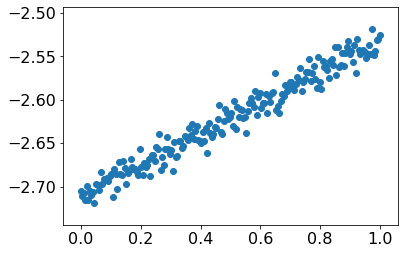

In [508]:
plt.figure()
plt.scatter(x, y)

In [509]:
def joint_log_prob(x, y, m, b, std):
    rv_m = tfd.Normal(loc=0, scale=5)
    rv_b = tfd.Normal(loc=0, scale=5)
    rv_std = tfd.HalfCauchy(loc=0., scale=2.)
    
    y_mu = m*x + b
    rv_y = tfd.Normal(loc=y_mu, scale=std)
    
    log_prior = rv_m.log_prob(m) + rv_b.log_prob(b) + rv_std.log_prob(std)
    log_like = tf.reduce_sum(rv_y.log_prob(y))
    
    return log_prior + log_like

In [510]:
# define a closure over our joint_log_prob
def target_log_prob_fn(m, b, std):
    return joint_log_prob(x, y, m, b, std)

In [511]:
target_log_prob_fn(m, b, std)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([627.3838], dtype=float32)>

In [512]:
@tf.function(experimental_compile=True)
# @tf.function(autograph=False)
def do_sampling(current_state, num_results, num_burnin_steps):
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.01,
        num_leapfrog_steps=16)

    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=kernel,
        bijector=[tfb.Identity(),
                  tfb.Identity(),
                  tfb.Exp()]
    )
    
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(num_burnin_steps * 0.8))

#     kernel = tfp.mcmc.SimpleStepSizeAdaptation(
#         inner_kernel=kernel,
#         num_adaptation_steps=int(num_burnin_steps * 0.8))
    
    
    trace_fn = lambda _, pkr: [pkr.inner_results.inner_results.accepted_results.step_size,
                               pkr.inner_results.inner_results.log_accept_ratio]
    
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=current_state,
        kernel=kernel,
        trace_fn=trace_fn
    )

In [513]:
current_state = [
    0.01 * tf.ones([], name='init_m', dtype=tf.float32),
    0.01 * tf.ones([], name='init_b', dtype=tf.float32),
    1. * tf.ones([], name='init_std', dtype=tf.float32)
]

In [514]:
num_results = 50000
num_burnin_steps = 500

In [515]:
%%time
samples, [step_size, log_accept_ratio] = do_sampling(current_state=current_state, num_results=num_results, num_burnin_steps=num_burnin_steps)

CPU times: user 4.2 s, sys: 57.8 ms, total: 4.26 s
Wall time: 4.28 s


In [516]:
samples[0].shape

TensorShape([50000])

In [517]:
m

array([0.1779003], dtype=float32)

In [518]:
b

array([-2.7096226], dtype=float32)

Text(0.5, 1.0, 'std')

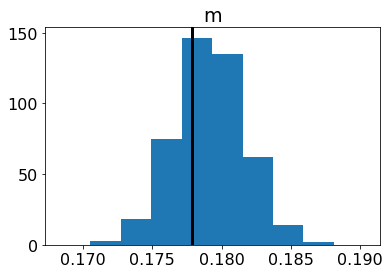

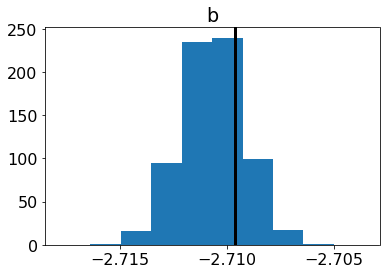

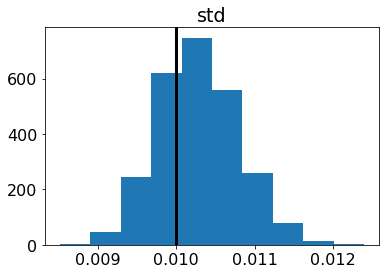

In [524]:
plt.figure()
plt.hist(samples[0], density=True);
plt.axvline(m, c='k', lw=3)
plt.title('m')


plt.figure()
plt.hist(samples[1], density=True);
plt.axvline(b, c='k', lw=3)
plt.title('b')


plt.figure()
plt.hist(samples[2], density=True);
plt.axvline(std, c='k', lw=3)
plt.title('std')

Text(0.5, 1.0, 'std')

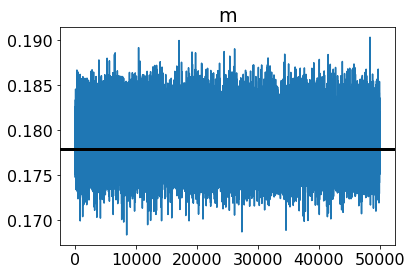

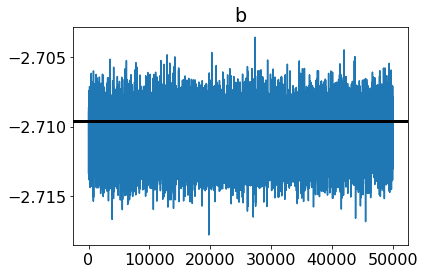

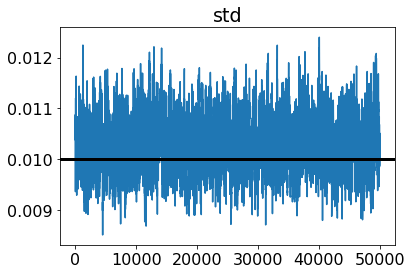

In [520]:
xx = np.arange(num_results)

plt.figure()
plt.plot(xx, samples[0]);
plt.axhline(m, c='k', lw=3)
plt.title('m')


plt.figure()
plt.plot(xx, samples[1]);
plt.axhline(b, c='k', lw=3)
plt.title('b')


plt.figure()
plt.plot(xx, samples[2]);
plt.axhline(std, c='k', lw=3)
plt.title('std')

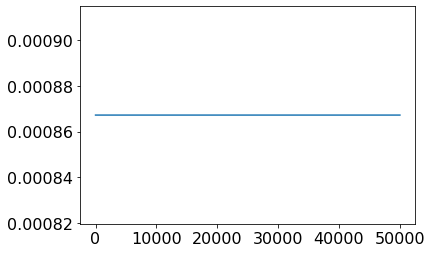

In [521]:
plt.figure()
plt.plot(xx, step_size)

In [522]:
log_accept_ratio.shape

TensorShape([50000])

In [523]:
np.mean(np.exp(log_accept_ratio))

1.0035833